In [12]:
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

In [136]:
# functions for bandpass filtering
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def calc_sync_index(df_voltage):
    sync_index = (df_voltage['senders'].nunique() * df_voltage.groupby('times')['V_m'].mean().std()) / df_voltage.groupby('senders')['V_m'].std().sum()
    return sync_index

def plot_avalanche(df_spike, num_bin):
    [avalanche_size,bins] = np.histogram(df_spike["times"],bins=int(num_bin))
    [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size)
    plt.plot(bins_avalanche_size[:-1], hist_avalanche_size)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('size of avalanches')
    plt.ylabel('Frequency')
    
def calc_avalanche_size(df_spike, num_bin):
    [avalanche_array,bins] = np.histogram(df_spike["times"],bins=int(num_bin))
    avalanche_size = 0
    asize_list = []
    for avalanche in avalanche_array:
        if avalanche == 0 and avalanche_size != 0:
            asize_list.append(avalanche_size)
            avalanche_size = 0
        elif avalanche == 0 and avalanche_size == 0:
            avalanche_size = 0
        else:
            avalanche_size += avalanche
    asize_list.append(avalanche_size)
    return np.array(asize_list)

def loglog_avalanche(df_spike, num_bin):
    avalanche_size = calc_avalanche_size(df_spike, num_bin)
    [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(1.0),np.log10(100.0), 100),density=True)
    nonzero_index = np.nonzero(hist_avalanche_size)
    bins_avalanche_size = bins_avalanche_size[nonzero_index]
    hist_avalanche_size = hist_avalanche_size[nonzero_index]
    plt.plot(bins_avalanche_size, hist_avalanche_size)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('size of avalanches')
    plt.ylabel('Frequency')

In [3]:
# set the parameters of Wang&Buzaki into hh model
parameters_wang_buzsaki = {
    "t_ref": 2,
    "g_Na": 3500,
    "g_K": 900,
    "g_L": 10,
    "C_m": 100,
    "E_Na": 55,
    "E_K": -90,
    "E_L": -65,
    "V_T": -55,
    "tau_syn_ex": 3,
    "tau_syn_in": 4,
    "E_ex": 0,
    "E_in": -75,
    "I_e": 0
}
nest.SetDefaults("hh_cond_exp_traub", parameters_wang_buzsaki)
# nest.CopyModel("hh_cond_exp_traub", "wang_buzsaki", params=parameters_wang_buzsaki)

In [ ]:
result_dir = pathlib.Path('./result_palmigiano')
result_dir.mkdir(exist_ok=True)
# nest.print_time = True
# PI_array = np.arange(0.1,1.0,0.1)
# input_rate_array = np.arange(0.1,1.0,0.1)
PI_array = np.array([0.5])
input_rate_array = np.array([0.5])
sync_index_array = np.zeros((len(input_rate_array),len(PI_array)))
for i_input_rate, input_rate in enumerate(input_rate_array):
    for i_PI, PI in enumerate(PI_array):
        nest.ResetKernel()
        # nest.CopyModel("hh_cond_exp_traub", "wang_buzsaki", params=parameters_wang_buzsaki)
        nest.SetDefaults("hh_cond_exp_traub", parameters_wang_buzsaki)
        T = 1000.0
        # create neurons
        NE = 1000
        NI = 250
        Vth = nest.GetDefaults("hh_cond_exp_traub", "V_T")
        Vrest = nest.GetDefaults("hh_cond_exp_traub", "E_L")
        E_neurons  = nest.Create("hh_cond_exp_traub", NE)
        dVms_E =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(E_neurons))]}
        E_neurons.set(dVms_E)
        I_neurons = nest.Create("hh_cond_exp_traub", NI)
        dVms_I =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(I_neurons))]}
        I_neurons.set(dVms_I)

        # create synapses
        PE = 0.3
        CE = int(PE * NE)  # the number of local excitatory connections
        CI = int(PI * NI)  # the number of local inhibitory connections
        d_mean = 1.5 # mean synaptic delay
        gs_E = 5 / NE
        gs_I = -236 / NI

        nest.Connect(E_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CE},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_E, 'delay': d_mean})

        nest.Connect(I_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CI},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_I, 'delay': d_mean})


        # create poisson inputs
        rate_poisson = input_rate*5e3 # PI*10kHz
        pg_e = nest.Create("poisson_generator")
        pg_e.set({"start": 0.0, "stop": T,"rate": rate_poisson})
        conn_spec_dict_E = {'rule': 'fixed_total_number', 'N': round(CE)}
        conn_spec_dict_I = {'rule': 'fixed_total_number', 'N': round(CI)}
        syn_spec_cidt_input = {'weight': 1.0, 'delay': 1.5}
        nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E, syn_spec=syn_spec_cidt_input)
        nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I, syn_spec=syn_spec_cidt_input)
        # nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E)
        # nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I)

        # connect devices
        voltmeter = nest.Create("voltmeter")
        nest.Connect(voltmeter, E_neurons)
        spikerecorder = nest.Create("spike_recorder")
        nest.Connect(E_neurons, spikerecorder)

        # run simulation
        nest.Simulate(T)

        # calculate LFP-like signal
        voltage = pd.DataFrame(voltmeter.get("events"))
        voltage_sorted = voltage.groupby("senders")[["times", "V_m"]].apply(lambda g: g.values.tolist()).to_dict()
        LFP_like = voltage.groupby('times')['V_m'].mean()
        LFP_like = LFP_like.to_numpy()
        time = voltmeter.get("events")["times"][::NE]
        
        [spectrum, freqs, t, im] = plt.specgram(LFP_like,Fs=1000,scale='dB')
        plt.close()

        # plot
        plt.figure(figsize=(7,5))
        plt.subplot(221)
        plt.plot(time[400:1000],LFP_like[400:1000])
        plt.title("LFP")
        plt.xlabel("Time [ms]")
        plt.ylabel("V [mV]")

        plt.subplot(222)
        fs = 1000.0
        lowcut = 30.0
        highcut = 100.0
        y = butter_bandpass_filter(LFP_like, lowcut, highcut, fs, order=6)
        plt.plot(time[400:1000],y[400:1000])
        plt.title("Gamma activity")
        plt.xlabel("Time [ms]")

        plt.subplot(223)
        plt.contourf(t[:20],freqs[10:30],spectrum[10:30,:20],cmap='plasma')
        plt.title("Spectrogram around Gamma")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Hz]")

        plt.subplot(224)
        plt.plot(freqs[2:25], np.mean(spectrum,1)[2:25])
        plt.title("Mean power")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Power [dB]")

        plt.tight_layout()
        fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + ".png"
        plt.savefig(result_dir / fname)
        plt.close()
        
        sync_index_array[i_input_rate,i_PI] = calc_sync_index(voltage)
        try:
            nest.raster_plot.from_device(spikerecorder, hist=True)
            plt.title('Population dynamics')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_raster.png"
            plt.savefig(result_dir / fname)
            
            plt.close()
            
            spike = pd.DataFrame(spikerecorder.get("events"))
            mean_firing_rate = spike.groupby('senders')["times"].apply(lambda g: np.mean(g.values.tolist())).mean()
            print(mean_firing_rate)
            
            # plot avalanche
            loglog_avalanche(spike,int(T*10.9))
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.png"
            plt.savefig(result_dir / fname)
            plt.close()
            
            # avalanche_size = calc_avalanche_size(spike,int(T/4))
            # [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(8.0),np.log10(800.0), 50),density=True)
            # plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
            # plt.yscale('log')
            # plt.xscale('log')
            # fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche_scatter.png"
            # plt.savefig(result_dir / fname)
            # plt.close()
        except:
            print("No spikes!")

In [172]:
result_dir = pathlib.Path('./result_palmigiano')
result_dir.mkdir(exist_ok=True)
# nest.print_time = True
# PI_array = np.arange(0.1,1.0,0.1)
# input_rate_array = np.arange(0.1,1.0,0.1)
PI_array = np.array([0.5])
input_rate_array = np.array([0.5])
sync_index_array = np.zeros((len(input_rate_array),len(PI_array)))
for i_input_rate, input_rate in enumerate(input_rate_array):
    for i_PI, PI in enumerate(PI_array):
        nest.ResetKernel()
        # nest.CopyModel("hh_cond_exp_traub", "wang_buzsaki", params=parameters_wang_buzsaki)
        nest.SetDefaults("hh_cond_exp_traub", parameters_wang_buzsaki)
        T = 1000.0
        # create neurons
        NE = 1000
        NI = 250
        Vth = nest.GetDefaults("hh_cond_exp_traub", "V_T")
        Vrest = nest.GetDefaults("hh_cond_exp_traub", "E_L")
        E_neurons  = nest.Create("hh_cond_exp_traub", NE)
        dVms_E =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(E_neurons))]}
        E_neurons.set(dVms_E)
        I_neurons = nest.Create("hh_cond_exp_traub", NI)
        dVms_I =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(I_neurons))]}
        I_neurons.set(dVms_I)

        # create synapses
        PE = 0.3
        CE = int(PE * NE)  # the number of local excitatory connections
        CI = int(PI * NI)  # the number of local inhibitory connections
        d_mean = 1.5 # mean synaptic delay
        gs_E = 5 / NE
        gs_I = -200 / NI

        nest.Connect(E_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CE},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_E, 'delay': d_mean})

        nest.Connect(I_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CI},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_I, 'delay': d_mean})


        # create poisson inputs
        rate_poisson = input_rate*10e3 # PI*10kHz
        pg_e = nest.Create("poisson_generator")
        pg_e.set({"start": 0.0, "stop": T,"rate": rate_poisson})
        conn_spec_dict_E = {'rule': 'fixed_total_number', 'N': round(CE)}
        conn_spec_dict_I = {'rule': 'fixed_total_number', 'N': round(CI)}
        syn_spec_cidt_input = {'weight': 1.0, 'delay': 1.5}
        nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E, syn_spec=syn_spec_cidt_input)
        nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I, syn_spec=syn_spec_cidt_input)
        # nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E)
        # nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I)

        # connect devices
        voltmeter = nest.Create("voltmeter")
        nest.Connect(voltmeter, E_neurons)
        spikerecorder = nest.Create("spike_recorder")
        nest.Connect(E_neurons, spikerecorder)

        # run simulation
        nest.Simulate(T)

        # calculate LFP-like signal
        voltage = pd.DataFrame(voltmeter.get("events"))
        voltage_sorted = voltage.groupby("senders")[["times", "V_m"]].apply(lambda g: g.values.tolist()).to_dict()
        LFP_like = voltage.groupby('times')['V_m'].mean()
        LFP_like = LFP_like.to_numpy()
        time = voltmeter.get("events")["times"][::NE]
        
        [spectrum, freqs, t, im] = plt.specgram(LFP_like,Fs=1000,scale='dB')
        plt.close()

        # plot
        plt.figure(figsize=(7,5))
        plt.subplot(221)
        plt.plot(time[400:1000],LFP_like[400:1000])
        plt.title("LFP")
        plt.xlabel("Time [ms]")
        plt.ylabel("V [mV]")

        plt.subplot(222)
        fs = 1000.0
        lowcut = 30.0
        highcut = 100.0
        y = butter_bandpass_filter(LFP_like, lowcut, highcut, fs, order=6)
        plt.plot(time[400:1000],y[400:1000])
        plt.title("Gamma activity")
        plt.xlabel("Time [ms]")

        plt.subplot(223)
        plt.contourf(t[:20],freqs[10:30],spectrum[10:30,:20],cmap='plasma')
        plt.title("Spectrogram around Gamma")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Hz]")

        plt.subplot(224)
        plt.plot(freqs[2:25], np.mean(spectrum,1)[2:25])
        plt.title("Mean power")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Power [dB]")

        plt.tight_layout()
        fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + ".png"
        plt.savefig(result_dir / fname)
        plt.close()
        
        sync_index_array[i_input_rate,i_PI] = calc_sync_index(voltage)
        try:
            nest.raster_plot.from_device(spikerecorder, hist=True)
            plt.title('Population dynamics')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_raster.png"
            plt.savefig(result_dir / fname)
            
            plt.close()
            
            spike = pd.DataFrame(spikerecorder.get("events"))
            mean_firing_rate = spike.groupby('senders')["times"].apply(lambda g: np.mean(g.values.tolist())).mean()
            print(mean_firing_rate)
            
            # plot avalanche
            loglog_avalanche(spike,int(T*10.9))
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.png"
            plt.savefig(result_dir / fname)
            plt.close()
            
            # avalanche_size = calc_avalanche_size(spike,int(T/4))
            # [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(8.0),np.log10(800.0), 50),density=True)
            # plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
            # plt.yscale('log')
            # plt.xscale('log')
            # fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche_scatter.png"
            # plt.savefig(result_dir / fname)
            # plt.close()
        except:
            print("No spikes!")


Jun 29 06:27:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 06:27:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 06:27:20 SimulationManager::run [Info]: 
    Simulation finished.
496.78444841968854


In [157]:

# plot
plt.figure(figsize=(7,5))
plt.subplot(221)
plt.plot(time[400:1000],LFP_like[400:1000])
plt.title("LFP")
plt.xlabel("Time [ms]")
plt.ylabel("V [mV]")

plt.subplot(222)
fs = 1000.0
lowcut = 30.0
highcut = 100.0
y = butter_bandpass_filter(LFP_like, lowcut, highcut, fs, order=6)
plt.plot(time[400:1000],y[400:1000])
plt.title("Gamma activity")
plt.xlabel("Time [ms]")

plt.subplot(223)
plt.contourf(t[:20],freqs[10:30],spectrum[10:30,:20],cmap='plasma')
plt.title("Spectrogram around Gamma")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

plt.subplot(224)
plt.plot(freqs[2:25], np.mean(spectrum,1)[2:25])
plt.title("Mean power")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")

plt.tight_layout()
fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + ".png"
plt.savefig(result_dir / fname)
plt.close()

sync_index_array[i_input_rate,i_PI] = calc_sync_index(voltage)
try:
    nest.raster_plot.from_device(spikerecorder, hist=True)
    plt.title('Population dynamics')
    fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_raster.png"
    plt.savefig(result_dir / fname)
    
    plt.close()
    
    spike = pd.DataFrame(spikerecorder.get("events"))
    mean_firing_rate = spike.groupby('senders')["times"].apply(lambda g: np.mean(g.values.tolist())).mean()
    print(mean_firing_rate)
    
    # plot avalanche
    loglog_avalanche(spike,int(T*10.9))
    fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.png"
    plt.savefig(result_dir / fname)
    plt.close()
    
    # avalanche_size = calc_avalanche_size(spike,int(T/4))
    # [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(8.0),np.log10(800.0), 50),density=True)
    # plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
    # plt.yscale('log')
    # plt.xscale('log')
    # fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche_scatter.png"
    # plt.savefig(result_dir / fname)
    # plt.close()
except:
    print("No spikes!")


4998.759093870326


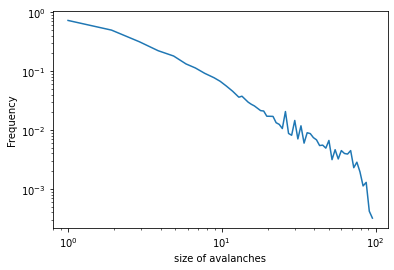

In [163]:
loglog_avalanche(spike,int(T*10.4))

Text(0.5, 1.0, 'Synchronization index')

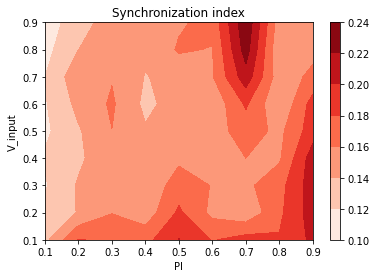

In [16]:
cont = plt.contourf(PI_array,input_rate_array,sync_index_array,cmap='Reds')
plt.xlabel('PI')
plt.ylabel('V_input')
plt.colorbar(cont)
plt.title('Synchronization index')


Jun 29 00:55:55 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:55:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 00:56:20 SimulationManager::run [Info]: 
    Simulation finished.
1003.0632011664353
No spikes!

Jun 29 00:56:24 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:56:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 00:56:54 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.1732829797038
No spikes!

Jun 29 00:57:00 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:57:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 00:57:30 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1003.4982709548626
No spikes!

Jun 29 00:57:36 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:57:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 00:58:04 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


991.0226967687637
No spikes!

Jun 29 00:58:09 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:58:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 00:58:32 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1009.6805883854881
No spikes!

Jun 29 00:58:38 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:58:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 00:59:05 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


982.2721607123613
No spikes!

Jun 29 00:59:09 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:59:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 00:59:29 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


988.1825285306426
No spikes!

Jun 29 00:59:34 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:59:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 00:59:54 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


954.3151364276547
No spikes!

Jun 29 00:59:58 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 00:59:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:00:19 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


979.4416568210318
No spikes!

Jun 29 01:00:24 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:00:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:00:46 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.4574029728877
No spikes!

Jun 29 01:00:50 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:00:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:01:12 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.3694441391227
No spikes!

Jun 29 01:01:17 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:01:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:01:38 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1003.7827042121623
No spikes!

Jun 29 01:01:42 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:01:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:02:03 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1002.5546874170508
No spikes!

Jun 29 01:02:08 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:02:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:02:29 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


989.3275622045724
No spikes!

Jun 29 01:02:34 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:02:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:02:55 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


992.1472950717283
No spikes!

Jun 29 01:03:00 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:03:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:03:22 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


990.9015967019579
No spikes!

Jun 29 01:03:27 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:03:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:03:48 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


972.3754658182274
No spikes!

Jun 29 01:03:52 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:03:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:04:13 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


938.876718519006
No spikes!

Jun 29 01:04:18 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:04:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:04:40 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1002.1559517299672
No spikes!

Jun 29 01:04:45 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:04:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:05:07 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1002.3389835083174
No spikes!

Jun 29 01:05:13 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:05:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:05:33 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.7910795000732
No spikes!

Jun 29 01:05:38 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:05:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:05:59 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.2743868656835
No spikes!

Jun 29 01:06:04 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:06:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:06:26 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.0558645225304
No spikes!

Jun 29 01:06:31 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:06:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:06:53 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.7583216440628
No spikes!

Jun 29 01:06:58 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:06:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:07:20 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


995.7956769642427
No spikes!

Jun 29 01:07:26 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:07:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:07:48 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


991.2407634809792
No spikes!

Jun 29 01:07:52 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:07:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:08:14 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


967.0478048809995
No spikes!

Jun 29 01:08:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:08:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:08:42 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.9526690740365
No spikes!

Jun 29 01:08:48 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:08:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:09:11 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.3298497545137
No spikes!

Jun 29 01:09:14 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:09:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:09:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.4827361604952
No spikes!

Jun 29 01:09:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:09:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:10:06 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.9508669406209
No spikes!

Jun 29 01:10:12 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:10:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:10:35 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.9426058462731
No spikes!

Jun 29 01:10:41 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:10:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:11:04 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


996.6525575376014
No spikes!

Jun 29 01:11:10 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:11:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:11:33 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


995.5634229463258
No spikes!

Jun 29 01:11:36 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:11:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:12:00 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


990.6358226856273
No spikes!

Jun 29 01:12:09 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:12:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:12:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


975.2288315651829
No spikes!

Jun 29 01:12:42 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:12:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:13:21 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.4757247539095
No spikes!

Jun 29 01:13:29 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:13:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:13:52 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.229897164041
No spikes!

Jun 29 01:13:57 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:13:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:14:20 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.088441882949
No spikes!

Jun 29 01:14:26 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:14:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:14:50 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.3378034835614
No spikes!

Jun 29 01:14:57 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:14:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:15:21 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.4176243279128
No spikes!

Jun 29 01:15:26 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:15:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:15:49 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.0174270238632
No spikes!

Jun 29 01:15:55 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:15:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:16:18 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1002.7728551564015
No spikes!

Jun 29 01:16:23 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:16:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:16:44 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.6115411356764
No spikes!

Jun 29 01:16:49 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:16:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:17:11 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


986.1429202537016
No spikes!

Jun 29 01:17:18 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:17:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:17:40 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.3116813502702
No spikes!

Jun 29 01:17:45 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:17:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:18:08 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.5257702479712
No spikes!

Jun 29 01:18:15 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:18:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:18:38 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.3679127131574
No spikes!

Jun 29 01:18:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:18:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:19:06 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.1619907880994
No spikes!

Jun 29 01:19:13 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:19:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:19:36 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.196169747229
No spikes!

Jun 29 01:19:41 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:19:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:20:05 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.3418110229215
No spikes!

Jun 29 01:20:10 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:20:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:20:33 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.7333918799494
No spikes!

Jun 29 01:20:39 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:20:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:21:03 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.3201032748362
No spikes!

Jun 29 01:21:08 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:21:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:21:32 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


991.657960789498
No spikes!

Jun 29 01:21:37 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:21:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:22:01 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.7464126930785
No spikes!

Jun 29 01:22:08 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:22:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:22:32 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.2636671940264
No spikes!

Jun 29 01:22:37 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:22:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:23:04 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.820881344854
No spikes!

Jun 29 01:23:11 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:23:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:23:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.2785151053664
No spikes!

Jun 29 01:23:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:23:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:24:07 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.3063633047923
No spikes!

Jun 29 01:24:13 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:24:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:24:39 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


997.804855998295
No spikes!

Jun 29 01:24:44 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:24:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:25:09 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1002.3201734105426
No spikes!

Jun 29 01:25:16 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:25:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:25:41 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.1753822234436
No spikes!

Jun 29 01:25:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:25:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:26:10 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


996.6452734159466
No spikes!

Jun 29 01:26:15 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:26:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:26:36 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.526501300517
No spikes!

Jun 29 01:26:41 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:26:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:27:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.2496731072371
No spikes!

Jun 29 01:27:07 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:27:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:27:28 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.1216838919602
No spikes!

Jun 29 01:27:35 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:27:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:27:57 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.9036328007611
No spikes!

Jun 29 01:28:01 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:28:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:28:23 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.2224229843304
No spikes!

Jun 29 01:28:27 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:28:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:28:48 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.05051978861
No spikes!

Jun 29 01:28:53 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:28:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:29:14 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.9272400139758
No spikes!

Jun 29 01:29:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:29:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:29:40 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.7344910918431
No spikes!

Jun 29 01:29:45 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:29:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:30:06 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


995.2799095204784
No spikes!

Jun 29 01:30:13 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:30:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:30:34 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.5648325342918
No spikes!

Jun 29 01:30:39 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:30:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:31:00 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.0369499907971
No spikes!

Jun 29 01:31:05 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:31:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:31:27 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.9287224285185
No spikes!

Jun 29 01:31:31 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:31:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:31:53 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.5831088222105
No spikes!

Jun 29 01:31:58 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:31:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:32:19 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.7607258627755
No spikes!

Jun 29 01:32:25 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:32:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:32:46 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.3642689354367
No spikes!

Jun 29 01:32:51 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:32:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:33:12 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.3985261078114
No spikes!

Jun 29 01:33:17 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:33:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:33:41 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.6475702604027
No spikes!

Jun 29 01:33:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:33:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:34:08 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1069195643.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.0090641428095
No spikes!


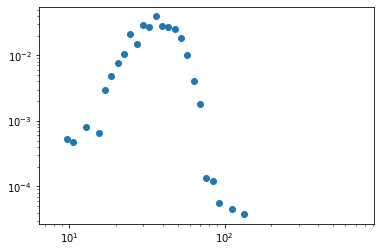

In [6]:
result_dir = pathlib.Path('./result_palmigiano_2')
result_dir.mkdir(exist_ok=True)
# nest.print_time = True
PI_array = np.arange(0.1,1.0,0.1)
input_rate_array = np.arange(1,10)
# PI_array = np.array([0.2])
# input_rate_array = np.array([0.1])
sync_index_array = np.zeros((len(input_rate_array),len(PI_array)))
for i_input_rate, input_rate in enumerate(input_rate_array):
    for i_PI, PI in enumerate(PI_array):
        nest.ResetKernel()
        # nest.CopyModel("hh_cond_exp_traub", "wang_buzsaki", params=parameters_wang_buzsaki)
        nest.SetDefaults("hh_cond_exp_traub", parameters_wang_buzsaki)
        T = 2000.0
        # create neurons
        NE = 1000
        NI = 250
        Vth = nest.GetDefaults("hh_cond_exp_traub", "V_T")
        Vrest = nest.GetDefaults("hh_cond_exp_traub", "E_L")
        E_neurons  = nest.Create("hh_cond_exp_traub", NE)
        dVms_E =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(E_neurons))]}
        E_neurons.set(dVms_E)
        I_neurons = nest.Create("hh_cond_exp_traub", NI)
        dVms_I =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(I_neurons))]}
        I_neurons.set(dVms_I)

        # create synapses
        PE = 0.3
        CE = int(PE * NE)  # the number of local excitatory connections
        CI = int(PI * NI)  # the number of local inhibitory connections
        d_mean = 1.5 # mean synaptic delay
        gs_E = 5 / CE
        gs_I = -200 / CI

        nest.Connect(E_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CE},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_E, 'delay': d_mean})

        nest.Connect(I_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CI},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_I, 'delay': d_mean})


        # create poisson inputs
        rate_poisson = input_rate*1e3 # PI*10kHz
        pg_e = nest.Create("poisson_generator")
        pg_e.set({"start": 0.0, "stop": T,"rate": rate_poisson})
        conn_spec_dict_E = {'rule': 'fixed_total_number', 'N': round(CE)}
        conn_spec_dict_I = {'rule': 'fixed_total_number', 'N': round(CI)}
        syn_spec_cidt_input = {'weight': 3.0 , 'delay': 1.5}
        nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E, syn_spec=syn_spec_cidt_input)
        nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I, syn_spec=syn_spec_cidt_input)
        # nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E)
        # nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I)

        # connect devices
        voltmeter = nest.Create("voltmeter")
        nest.Connect(voltmeter, E_neurons)
        spikerecorder = nest.Create("spike_recorder")
        nest.Connect(E_neurons, spikerecorder)

        # run simulation
        nest.Simulate(T)

        # calculate LFP-like signal
        voltage = pd.DataFrame(voltmeter.get("events"))
        voltage_sorted = voltage.groupby("senders")[["times", "V_m"]].apply(lambda g: g.values.tolist()).to_dict()
        LFP_like = voltage.groupby('times')['V_m'].mean()
        LFP_like = LFP_like.to_numpy()
        time = voltmeter.get("events")["times"][::NE]
        
        [spectrum, freqs, t, im] = plt.specgram(LFP_like,Fs=1000,scale='dB')
        plt.close()

        # plot
        plt.figure(figsize=(7,5))
        plt.subplot(221)
        plt.plot(time[400:1000],LFP_like[400:1000])
        plt.title("LFP")
        plt.xlabel("Time [ms]")
        plt.ylabel("V [mV]")

        plt.subplot(222)
        fs = 1000.0
        lowcut = 30.0
        highcut = 100.0
        y = butter_bandpass_filter(LFP_like, lowcut, highcut, fs, order=6)
        plt.plot(time[400:1000],y[400:1000])
        plt.title("Gamma activity")
        plt.xlabel("Time [ms]")

        plt.subplot(223)
        plt.contourf(t[:20],freqs[5:25],spectrum[5:25,:20],cmap='plasma')
        plt.title("Spectrogram around Gamma")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Hz]")

        plt.subplot(224)
        plt.plot(freqs[2:18], np.mean(spectrum,1)[2:18])
        plt.title("Mean power")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Power [dB]")

        plt.tight_layout()
        fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + ".png"
        plt.savefig(result_dir / fname)
        plt.close()
        
        sync_index_array[i_input_rate,i_PI] = calc_sync_index(voltage)
        try:
            nest.raster_plot.from_device(spikerecorder, hist=True)
            plt.title('Population dynamics')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_raster.png"
            plt.savefig(result_dir / fname)
            
            plt.close()
            
            spike = pd.DataFrame(spikerecorder.get("events"))
            mean_firing_rate = spike.groupby('senders')["times"].apply(lambda g: np.mean(g.values.tolist())).mean()
            print(mean_firing_rate)
            
            # plot avalanche
            plot_avalanche(spike,T)
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.png"
            plt.savefig(result_dir / fname)
            plt.close()
            
            [avalanche_size,bins] = np.histogram(spike["times"],bins=int(T))
            [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(8.0),np.log10(800.0), 50),density=True)
            plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
            plt.yscale('log')
            plt.xscale('log')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche_scatter.png"
            plt.savefig(result_dir / fname)
            plt.close()
        except:
            print("No spikes!")

Text(0.5, 1.0, 'Synchronization index')

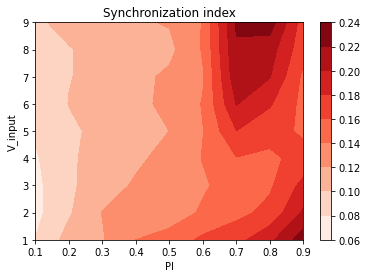

In [7]:
cont = plt.contourf(PI_array,input_rate_array,sync_index_array,cmap='Reds')
plt.xlabel('PI')
plt.ylabel('V_input')
plt.colorbar(cont)
plt.title('Synchronization index')


Jun 29 01:34:13 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:34:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:34:30 SimulationManager::run [Info]: 
    Simulation finished.
1052.502483520378


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:34:38 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:34:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:34:55 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


968.3327397950011


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:34:59 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:34:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:35:16 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1064.9497020868005


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:35:20 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:35:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:35:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1062.2195940821043


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:35:40 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:35:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:35:58 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


996.9763376196047


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:36:01 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:36:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:36:19 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1111.940850899705


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:36:22 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:36:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:36:40 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


964.4213428148794


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:36:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:36:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:37:00 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1048.3936309523808


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:37:04 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:37:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:37:21 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


980.6763577294652


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:37:25 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:37:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:37:47 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1032.1719129055414
No spikes!

Jun 29 01:37:52 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:37:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:38:16 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1010.0438324396289
No spikes!

Jun 29 01:38:22 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:38:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:38:49 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1007.1399047910999
No spikes!

Jun 29 01:38:53 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:38:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:39:13 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1074.7229059449494


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:39:18 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:39:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:39:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1041.9789615721943


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:39:42 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:39:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:40:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1032.7860430776607


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:40:07 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:40:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:40:27 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1020.6362982688197


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:40:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:40:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:40:52 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


953.0028038999902


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:40:56 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:40:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:41:16 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1007.3177580108411


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:41:22 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:41:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:41:42 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1003.4249195847764
No spikes!

Jun 29 01:41:47 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:41:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:42:07 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1006.5798227014985
No spikes!

Jun 29 01:42:12 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:42:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:42:36 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1007.3262847216159
No spikes!

Jun 29 01:42:41 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:42:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:43:01 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1010.5758612360632
No spikes!

Jun 29 01:43:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:43:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:43:27 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.8296745857982
No spikes!

Jun 29 01:43:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:43:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:43:53 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1007.0732887034958
No spikes!

Jun 29 01:43:58 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:43:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:44:20 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1012.6422721681884
No spikes!

Jun 29 01:44:25 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:44:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:44:43 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


980.6384017611514


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:44:49 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:44:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:45:07 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1009.9564272933441


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 01:45:12 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:45:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:45:31 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1006.1595038615457
No spikes!

Jun 29 01:45:35 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:45:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:45:54 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1013.2547696885906
No spikes!

Jun 29 01:45:59 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:45:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:46:18 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1019.0284570334804
No spikes!

Jun 29 01:46:22 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:46:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:46:40 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


976.0188285302943
No spikes!

Jun 29 01:46:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:46:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:47:04 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1031.4733710810071
No spikes!

Jun 29 01:47:09 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:47:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:47:27 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


994.8283750187923
No spikes!

Jun 29 01:47:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:47:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:47:51 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1015.4577389139189
No spikes!

Jun 29 01:47:56 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:47:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:48:15 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1008.0655272447584
No spikes!

Jun 29 01:48:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:48:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:48:38 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1013.2245372396354
No spikes!

Jun 29 01:48:44 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:48:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:49:03 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.266275595029
No spikes!

Jun 29 01:49:08 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:49:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:49:27 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.931543972254
No spikes!

Jun 29 01:49:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:49:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:49:50 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1014.5296224705073
No spikes!

Jun 29 01:49:56 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:49:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:50:14 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1004.5732619336266
No spikes!

Jun 29 01:50:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:50:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:50:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


997.5986004284673
No spikes!

Jun 29 01:50:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:50:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:51:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1005.3121280311043
No spikes!

Jun 29 01:51:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:51:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:51:25 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


974.8779210084456
No spikes!

Jun 29 01:51:29 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:51:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:51:47 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


985.3980003035622
No spikes!

Jun 29 01:51:54 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:51:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:52:12 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


990.3733046026799
No spikes!

Jun 29 01:52:17 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:52:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:52:36 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1005.3918055483235
No spikes!

Jun 29 01:52:42 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:52:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:53:01 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.2632915182563
No spikes!

Jun 29 01:53:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:53:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:53:25 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


995.6843012737388
No spikes!

Jun 29 01:53:31 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:53:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:53:51 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1005.3795323096825
No spikes!

Jun 29 01:53:55 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:53:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:54:14 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


975.1354378407212
No spikes!

Jun 29 01:54:20 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:54:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:54:38 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1014.8380894375271
No spikes!

Jun 29 01:54:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:54:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:55:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1007.5698047044574
No spikes!

Jun 29 01:55:08 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:55:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:55:27 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


993.3318898065553
No spikes!

Jun 29 01:55:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:55:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:55:50 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


982.2657549059937
No spikes!

Jun 29 01:55:55 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:55:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:56:14 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1001.4227402738184
No spikes!

Jun 29 01:56:21 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:56:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:56:42 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1002.9333119346205
No spikes!

Jun 29 01:56:50 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:56:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:57:23 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.9677325727066
No spikes!

Jun 29 01:57:29 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:57:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:57:51 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


996.073544967311
No spikes!

Jun 29 01:57:58 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:57:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:58:20 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1005.4685009428871
No spikes!

Jun 29 01:58:28 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:58:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:58:55 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


992.5663435773049
No spikes!

Jun 29 01:59:00 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:59:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 01:59:20 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


990.2835124556306
No spikes!

Jun 29 01:59:29 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 01:59:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:00:06 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


971.8389395024457
No spikes!

Jun 29 02:00:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:00:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:01:01 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


997.4809162555242
No spikes!

Jun 29 02:01:07 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:01:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:01:29 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.2506027521498
No spikes!

Jun 29 02:01:34 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:01:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:01:58 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.5911588159128
No spikes!

Jun 29 02:02:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:02:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:02:29 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1000.2189603886778
No spikes!

Jun 29 02:02:35 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:02:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:02:56 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


991.3116143562304
No spikes!

Jun 29 02:03:02 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:03:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:03:25 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.7931855258169
No spikes!

Jun 29 02:03:30 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:03:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:03:50 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


995.8543937103166
No spikes!

Jun 29 02:03:58 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:03:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:04:20 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


993.9616810827981
No spikes!

Jun 29 02:04:26 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:04:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:04:49 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


942.6818695814974
No spikes!

Jun 29 02:04:54 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:04:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:05:18 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


972.3433403220561
No spikes!

Jun 29 02:05:24 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:05:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:05:56 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1008.2405079330875
No spikes!

Jun 29 02:06:07 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:06:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:06:29 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


993.9247804193061
No spikes!

Jun 29 02:06:38 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:06:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:07:03 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.9320980230457
No spikes!

Jun 29 02:07:10 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:07:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:07:33 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1012.3166646757172
No spikes!

Jun 29 02:07:39 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:07:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:08:00 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


988.959866723714
No spikes!

Jun 29 02:08:07 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:08:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:08:31 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


992.5059262735592
No spikes!

Jun 29 02:08:38 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:08:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:09:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


993.7429119273638
No spikes!

Jun 29 02:09:09 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:09:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:09:31 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


972.0935828963213
No spikes!

Jun 29 02:09:37 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:09:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:10:00 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/3189312826.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


973.5255290390021
No spikes!


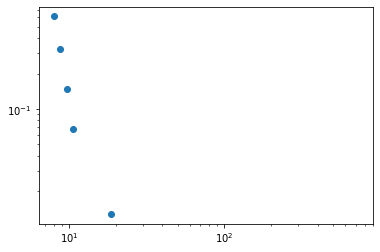

In [8]:
result_dir = pathlib.Path('./result_palmigiano_3')
result_dir.mkdir(exist_ok=True)
# nest.print_time = True
PI_array = np.arange(0.1,1.0,0.1)
input_rate_array = np.arange(1,10)
# PI_array = np.array([0.2])
# input_rate_array = np.array([0.1])
sync_index_array = np.zeros((len(input_rate_array),len(PI_array)))
for i_input_rate, input_rate in enumerate(input_rate_array):
    for i_PI, PI in enumerate(PI_array):
        nest.ResetKernel()
        # nest.CopyModel("hh_cond_exp_traub", "wang_buzsaki", params=parameters_wang_buzsaki)
        nest.SetDefaults("hh_cond_exp_traub", parameters_wang_buzsaki)
        T = 2000.0
        # create neurons
        NE = 1000
        NI = 250
        Vth = nest.GetDefaults("hh_cond_exp_traub", "V_T")
        Vrest = nest.GetDefaults("hh_cond_exp_traub", "E_L")
        E_neurons  = nest.Create("hh_cond_exp_traub", NE)
        dVms_E =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(E_neurons))]}
        E_neurons.set(dVms_E)
        I_neurons = nest.Create("hh_cond_exp_traub", NI)
        dVms_I =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(I_neurons))]}
        I_neurons.set(dVms_I)

        # create synapses
        PE = 0.3
        CE = int(PE * NE)  # the number of local excitatory connections
        CI = int(PI * NI)  # the number of local inhibitory connections
        d_mean = 1.5 # mean synaptic delay
        gs_E = 5 / CE
        gs_I = -200 / CI

        nest.Connect(E_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CE},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_E, 'delay': d_mean})

        nest.Connect(I_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CI},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_I, 'delay': d_mean})


        # create poisson inputs
        rate_poisson = input_rate*1e2 # PI*10kHz
        pg_e = nest.Create("poisson_generator")
        pg_e.set({"start": 0.0, "stop": T,"rate": rate_poisson})
        conn_spec_dict_E = {'rule': 'fixed_total_number', 'N': round(CE)}
        conn_spec_dict_I = {'rule': 'fixed_total_number', 'N': round(CI)}
        syn_spec_cidt_input = {'weight': 3.0 , 'delay': 1.5}
        nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E, syn_spec=syn_spec_cidt_input)
        nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I, syn_spec=syn_spec_cidt_input)
        # nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E)
        # nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I)

        # connect devices
        voltmeter = nest.Create("voltmeter")
        nest.Connect(voltmeter, E_neurons)
        spikerecorder = nest.Create("spike_recorder")
        nest.Connect(E_neurons, spikerecorder)

        # run simulation
        nest.Simulate(T)

        # calculate LFP-like signal
        voltage = pd.DataFrame(voltmeter.get("events"))
        voltage_sorted = voltage.groupby("senders")[["times", "V_m"]].apply(lambda g: g.values.tolist()).to_dict()
        LFP_like = voltage.groupby('times')['V_m'].mean()
        LFP_like = LFP_like.to_numpy()
        time = voltmeter.get("events")["times"][::NE]
        
        [spectrum, freqs, t, im] = plt.specgram(LFP_like,Fs=1000,scale='dB')
        plt.close()

        # plot
        plt.figure(figsize=(7,5))
        plt.subplot(221)
        plt.plot(time[400:1000],LFP_like[400:1000])
        plt.title("LFP")
        plt.xlabel("Time [ms]")
        plt.ylabel("V [mV]")

        plt.subplot(222)
        fs = 1000.0
        lowcut = 30.0
        highcut = 100.0
        y = butter_bandpass_filter(LFP_like, lowcut, highcut, fs, order=6)
        plt.plot(time[400:1000],y[400:1000])
        plt.title("Gamma activity")
        plt.xlabel("Time [ms]")

        plt.subplot(223)
        plt.contourf(t[:20],freqs[5:25],spectrum[5:25,:20],cmap='plasma')
        plt.title("Spectrogram around Gamma")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Hz]")

        plt.subplot(224)
        plt.plot(freqs[2:18], np.mean(spectrum,1)[2:18])
        plt.title("Mean power")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Power [dB]")

        plt.tight_layout()
        fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + ".png"
        plt.savefig(result_dir / fname)
        plt.close()
        
        sync_index_array[i_input_rate,i_PI] = calc_sync_index(voltage)
        try:
            nest.raster_plot.from_device(spikerecorder, hist=True)
            plt.title('Population dynamics')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_raster.png"
            plt.savefig(result_dir / fname)
            
            plt.close()
            
            spike = pd.DataFrame(spikerecorder.get("events"))
            mean_firing_rate = spike.groupby('senders')["times"].apply(lambda g: np.mean(g.values.tolist())).mean()
            print(mean_firing_rate)
            
            # plot avalanche
            plot_avalanche(spike,T)
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.png"
            plt.savefig(result_dir / fname)
            plt.close()
            
            [avalanche_size,bins] = np.histogram(spike["times"],bins=int(T))
            [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(8.0),np.log10(800.0), 50),density=True)
            plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
            plt.yscale('log')
            plt.xscale('log')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "gs_I_" + str(round(gs_I_,3)) + "_avalanche_scatter.png"
            plt.savefig(result_dir / fname)
            plt.close()
        except:
            print("No spikes!")

Text(0.5, 1.0, 'Synchronization index')

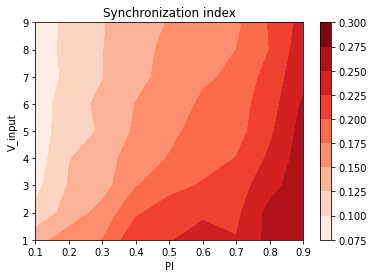

In [9]:
cont = plt.contourf(PI_array,input_rate_array,sync_index_array,cmap='Reds')
plt.xlabel('PI')
plt.ylabel('V_input')
plt.colorbar(cont)
plt.title('Synchronization index')


Jun 29 02:10:09 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:10:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:10:31 SimulationManager::run [Info]: 
    Simulation finished.
994.509313060194
No spikes!

Jun 29 02:10:41 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:10:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:11:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1009.6425526053598
No spikes!

Jun 29 02:11:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:11:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:11:28 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1019.9861024387744
No spikes!

Jun 29 02:11:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:11:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:11:54 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1014.6786197500907
No spikes!

Jun 29 02:11:59 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:11:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:12:18 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


901.5220898350922
No spikes!

Jun 29 02:12:22 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:12:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:12:44 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


871.2375345761336
No spikes!

Jun 29 02:12:49 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:12:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:13:11 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1064.3452136357416
No spikes!

Jun 29 02:13:16 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:13:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:13:36 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


925.1797056742279
No spikes!

Jun 29 02:13:40 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:13:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:13:59 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


983.8696916099774
No spikes!

Jun 29 02:14:03 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:14:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:14:25 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1014.3912186581155
No spikes!

Jun 29 02:14:29 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:14:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:14:50 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


952.8645905770395
No spikes!

Jun 29 02:14:55 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:14:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:15:15 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


962.4339539230424
No spikes!

Jun 29 02:15:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:15:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:15:38 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1011.0187488246158
No spikes!

Jun 29 02:15:42 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:15:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:16:01 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


983.5262862666099
No spikes!

Jun 29 02:16:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:16:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:16:25 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


945.0723519711576
No spikes!

Jun 29 02:16:29 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:16:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:16:48 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1183.5690621247008
No spikes!

Jun 29 02:16:53 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:16:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:17:12 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


943.1460510094956
No spikes!

Jun 29 02:17:16 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:17:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:17:35 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1199.4162065738244


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 02:17:39 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:17:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:18:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


973.2399094516336
No spikes!

Jun 29 02:18:07 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:18:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:18:29 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


972.7473351201953
No spikes!

Jun 29 02:18:33 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:18:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:18:54 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


982.3176185926792
No spikes!

Jun 29 02:18:58 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:18:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:19:17 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1037.497520503338
No spikes!

Jun 29 02:19:22 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:19:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:19:41 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


956.6871157433969
No spikes!

Jun 29 02:19:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:19:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:20:05 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1074.014940175704
No spikes!

Jun 29 02:20:10 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:20:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:20:28 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1018.211301528681
No spikes!

Jun 29 02:20:33 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:20:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:20:52 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


869.1414061331783
No spikes!

Jun 29 02:20:57 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:20:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:21:16 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1018.2456998501445


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 02:21:21 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:21:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:21:44 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1004.1253109808387
No spikes!

Jun 29 02:21:50 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:21:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:22:11 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


969.6780573705511
No spikes!

Jun 29 02:22:17 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:22:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:22:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


988.0323285657196
No spikes!

Jun 29 02:22:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:22:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:23:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1031.4557926564833
No spikes!

Jun 29 02:23:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:23:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:23:25 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


984.2650438290314
No spikes!

Jun 29 02:23:31 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:23:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:23:50 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1118.5974298482336
No spikes!

Jun 29 02:23:54 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:23:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:24:13 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


861.2012306903453
No spikes!

Jun 29 02:24:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:24:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:24:38 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


965.2614049593008
No spikes!

Jun 29 02:24:42 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:24:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:25:01 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.9711762788369
No spikes!

Jun 29 02:25:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:25:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:25:30 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1019.5573878207447
No spikes!

Jun 29 02:25:36 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:25:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:25:58 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


979.9469317827228
No spikes!

Jun 29 02:26:04 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:26:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:26:24 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


980.5760595821282
No spikes!

Jun 29 02:26:29 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:26:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:26:48 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


934.3984885172725
No spikes!

Jun 29 02:26:54 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:26:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:27:13 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1046.8165583823388
No spikes!

Jun 29 02:27:18 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:27:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:27:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


959.8604850757995
No spikes!

Jun 29 02:27:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:27:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:28:02 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1051.0075166682207
No spikes!

Jun 29 02:28:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:28:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:28:26 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1122.953163448759
No spikes!

Jun 29 02:28:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:28:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:28:50 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


938.5269869484026


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 02:28:55 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:28:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:29:20 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


993.4800448758112
No spikes!

Jun 29 02:29:26 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:29:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:29:48 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1041.8649648900218
No spikes!

Jun 29 02:29:53 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:29:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:30:14 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1002.2154666957266
No spikes!

Jun 29 02:30:20 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:30:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:30:40 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


938.5391563127537
No spikes!

Jun 29 02:30:44 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:30:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:31:04 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1010.6261308115564
No spikes!

Jun 29 02:31:10 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:31:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:31:30 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


951.197723788297
No spikes!

Jun 29 02:31:35 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:31:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:31:53 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


950.412150254816
No spikes!

Jun 29 02:32:00 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:32:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:32:19 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1135.7071654197987


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 02:32:24 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:32:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:32:44 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


967.0403602998979


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 02:32:48 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:32:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:33:11 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1006.5941201939484
No spikes!

Jun 29 02:33:16 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:33:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:33:37 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


971.6051415221435
No spikes!

Jun 29 02:33:42 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:33:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:34:01 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


985.659237258272
No spikes!

Jun 29 02:34:05 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:34:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:34:24 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


950.9018592659605
No spikes!

Jun 29 02:34:30 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:34:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:34:48 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1085.3307997350632
No spikes!

Jun 29 02:34:52 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:34:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:35:10 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1062.377786678798
No spikes!

Jun 29 02:35:14 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:35:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:35:32 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


992.453678284855
No spikes!

Jun 29 02:35:38 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:35:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:35:56 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


899.1347122817277
No spikes!

Jun 29 02:36:00 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:36:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:36:17 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1085.9526462259962


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 02:36:21 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:36:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:36:44 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


999.0423268193186
No spikes!

Jun 29 02:36:49 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:36:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:37:09 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


975.3408460145732
No spikes!

Jun 29 02:37:15 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:37:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:37:34 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1004.348986624799
No spikes!

Jun 29 02:37:39 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:37:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:37:57 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1052.9480072392441
No spikes!

Jun 29 02:38:01 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:38:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:38:19 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1130.4450486247738
No spikes!

Jun 29 02:38:23 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:38:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:38:41 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


934.1667087645935
No spikes!

Jun 29 02:38:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:38:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:39:03 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1118.0427481561376
No spikes!

Jun 29 02:39:08 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:39:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:39:25 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1200.3520734334343
No spikes!

Jun 29 02:39:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:39:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:39:49 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1043.0139247084262


/Users/shishikura/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in true_divide


No spikes!

Jun 29 02:39:53 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:39:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:40:17 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1006.7416598511287
No spikes!

Jun 29 02:40:22 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:40:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:40:42 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1010.5490840588739
No spikes!

Jun 29 02:40:47 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:40:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:41:06 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


944.2282865786528
No spikes!

Jun 29 02:41:11 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:41:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:41:29 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1060.101203726392
No spikes!

Jun 29 02:41:34 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:41:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:41:52 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1057.8538230695412
No spikes!

Jun 29 02:41:56 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:41:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:42:14 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


998.4920359407546
No spikes!

Jun 29 02:42:21 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:42:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:42:39 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


1046.567438425657
No spikes!

Jun 29 02:42:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:42:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:43:00 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


891.3857639579998
No spikes!

Jun 29 02:43:05 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 02:43:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 02:43:22 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/c1/t6zcxvm50pb8bzp756t43kv40000gn/T/ipykernel_44854/1752141640.py:72: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


923.8544964745902
No spikes!


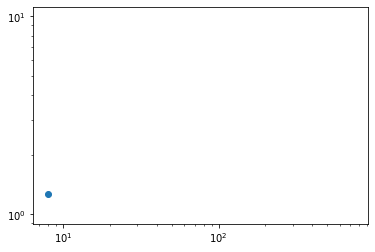

In [10]:
result_dir = pathlib.Path('./result_palmigiano_4')
result_dir.mkdir(exist_ok=True)
# nest.print_time = True
PI_array = np.arange(0.1,1.0,0.1)
input_rate_array = np.arange(1,10)
# PI_array = np.array([0.2])
# input_rate_array = np.array([0.1])
sync_index_array = np.zeros((len(input_rate_array),len(PI_array)))
for i_input_rate, input_rate in enumerate(input_rate_array):
    for i_PI, PI in enumerate(PI_array):
        nest.ResetKernel()
        # nest.CopyModel("hh_cond_exp_traub", "wang_buzsaki", params=parameters_wang_buzsaki)
        nest.SetDefaults("hh_cond_exp_traub", parameters_wang_buzsaki)
        T = 2000.0
        # create neurons
        NE = 1000
        NI = 250
        Vth = nest.GetDefaults("hh_cond_exp_traub", "V_T")
        Vrest = nest.GetDefaults("hh_cond_exp_traub", "E_L")
        E_neurons  = nest.Create("hh_cond_exp_traub", NE)
        dVms_E =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(E_neurons))]}
        E_neurons.set(dVms_E)
        I_neurons = nest.Create("hh_cond_exp_traub", NI)
        dVms_I =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(I_neurons))]}
        I_neurons.set(dVms_I)

        # create synapses
        PE = 0.3
        CE = int(PE * NE)  # the number of local excitatory connections
        CI = int(PI * NI)  # the number of local inhibitory connections
        d_mean = 1.5 # mean synaptic delay
        gs_E = 5 
        gs_I = -200 

        nest.Connect(E_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CE},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_E, 'delay': d_mean})

        nest.Connect(I_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CI},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_I, 'delay': d_mean})


        # create poisson inputs
        rate_poisson = input_rate*1e2 # PI*10kHz
        pg_e = nest.Create("poisson_generator")
        pg_e.set({"start": 0.0, "stop": T,"rate": rate_poisson})
        conn_spec_dict_E = {'rule': 'fixed_total_number', 'N': round(CE)}
        conn_spec_dict_I = {'rule': 'fixed_total_number', 'N': round(CI)}
        syn_spec_cidt_input = {'weight': 3.0 , 'delay': 1.5}
        nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E, syn_spec=syn_spec_cidt_input)
        nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I, syn_spec=syn_spec_cidt_input)
        # nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E)
        # nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I)

        # connect devices
        voltmeter = nest.Create("voltmeter")
        nest.Connect(voltmeter, E_neurons)
        spikerecorder = nest.Create("spike_recorder")
        nest.Connect(E_neurons, spikerecorder)

        # run simulation
        nest.Simulate(T)

        # calculate LFP-like signal
        voltage = pd.DataFrame(voltmeter.get("events"))
        voltage_sorted = voltage.groupby("senders")[["times", "V_m"]].apply(lambda g: g.values.tolist()).to_dict()
        LFP_like = voltage.groupby('times')['V_m'].mean()
        LFP_like = LFP_like.to_numpy()
        time = voltmeter.get("events")["times"][::NE]
        
        [spectrum, freqs, t, im] = plt.specgram(LFP_like,Fs=1000,scale='dB')
        plt.close()

        # plot
        plt.figure(figsize=(7,5))
        plt.subplot(221)
        plt.plot(time[400:1000],LFP_like[400:1000])
        plt.title("LFP")
        plt.xlabel("Time [ms]")
        plt.ylabel("V [mV]")

        plt.subplot(222)
        fs = 1000.0
        lowcut = 30.0
        highcut = 100.0
        y = butter_bandpass_filter(LFP_like, lowcut, highcut, fs, order=6)
        plt.plot(time[400:1000],y[400:1000])
        plt.title("Gamma activity")
        plt.xlabel("Time [ms]")

        plt.subplot(223)
        plt.contourf(t[:20],freqs[5:25],spectrum[5:25,:20],cmap='plasma')
        plt.title("Spectrogram around Gamma")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Hz]")

        plt.subplot(224)
        plt.plot(freqs[2:18], np.mean(spectrum,1)[2:18])
        plt.title("Mean power")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Power [dB]")

        plt.tight_layout()
        fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + ".png"
        plt.savefig(result_dir / fname)
        plt.close()
        
        sync_index_array[i_input_rate,i_PI] = calc_sync_index(voltage)
        try:
            nest.raster_plot.from_device(spikerecorder, hist=True)
            plt.title('Population dynamics')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_raster.png"
            plt.savefig(result_dir / fname)
            
            plt.close()
            
            spike = pd.DataFrame(spikerecorder.get("events"))
            mean_firing_rate = spike.groupby('senders')["times"].apply(lambda g: np.mean(g.values.tolist())).mean()
            print(mean_firing_rate)
            
            # plot avalanche
            plot_avalanche(spike,T)
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.png"
            plt.savefig(result_dir / fname)
            plt.close()
            
            [avalanche_size,bins] = np.histogram(spike["times"],bins=int(T))
            [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(8.0),np.log10(800.0), 50),density=True)
            plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
            plt.yscale('log')
            plt.xscale('log')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "gs_I_" + str(round(gs_I_,3)) + "_avalanche_scatter.png"
            plt.savefig(result_dir / fname)
            plt.close()
        except:
            print("No spikes!")

Text(0.5, 1.0, 'Synchronization index')

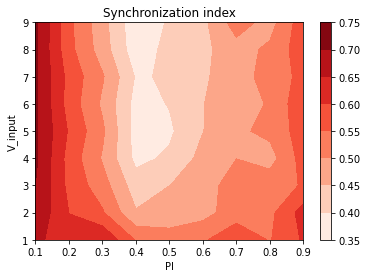

In [11]:
cont = plt.contourf(PI_array,input_rate_array,sync_index_array,cmap='Reds')
plt.xlabel('PI')
plt.ylabel('V_input')
plt.colorbar(cont)
plt.title('Synchronization index')

In [24]:
avalanche_size_array = calc_avalanche_size(spike, int(T/5))

(array([38., 12., 16.,  5.,  6.,  7.,  2.,  0.,  1.,  1.]),
 array([ 1. ,  3.4,  5.8,  8.2, 10.6, 13. , 15.4, 17.8, 20.2, 22.6, 25. ]),
 <BarContainer object of 10 artists>)

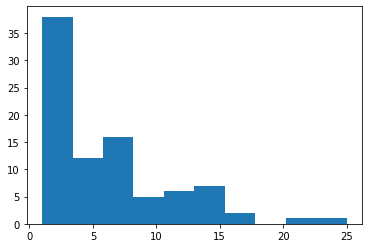

In [25]:
plt.hist(avalanche_size_array)

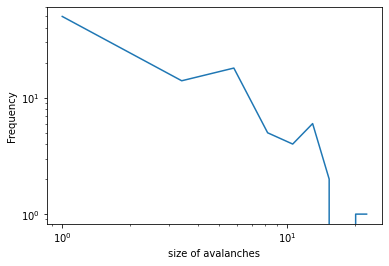

In [27]:
loglog_avalanche(spike, int(T/4))

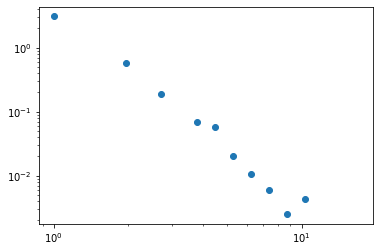

In [41]:
avalanche_size = calc_avalanche_size(spike,int(T))
[hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(1.0),np.log10(100.0), 19),density=True)
plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
plt.yscale('log')
plt.xscale('log')

In [40]:
np.unique(avalanche_size)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 12])